In [19]:
!pip install CBFV

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from CBFV.composition import generate_features

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/jupyter/2D/data/C2DB_TDSL_class.csv')

df.head(10)

,Formula,Thermodynamic stability level
0,Ag2,1.0
1,Ag2Au2Cl8,3.0
2,Ag2Br2,3.0
3,Ag2Br2N2,1.0
4,Ag2Br2O2,1.0
5,Ag2Br2S2,1.0
6,Ag2Br2S4,3.0
7,Ag2Br2Se2,2.0
8,Ag2Br2Se4,3.0
9,Ag2Br2Te4,3.0


In [23]:
list(df.columns)[1]

'Thermodynamic stability level'

In [24]:
rename_dict = {'Formula': 'formula', list(df.columns)[1]: 'target'}
df = df.rename(columns=rename_dict)
df.head()

,formula,target
0,Ag2,1.0
1,Ag2Au2Cl8,3.0
2,Ag2Br2,3.0
3,Ag2Br2N2,1.0
4,Ag2Br2O2,1.0


In [25]:
X_train_unscaled0, y_train0, formulae_train, skipped_train = generate_features(df, elem_prop='oliynyk', drop_duplicates=False, extend_features=False, sum_feat=True)

Processing Input Data: 100%|██████████| 2814/2814 [00:00<00:00, 12821.64it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 9556.88it/s]


	Creating Pandas Objects...


In [26]:
SEED = 42
X_train_unscaled1, X_test_unscaled, y_train1, y_test = train_test_split(X_train_unscaled0, y_train0, test_size=0.20, random_state=SEED)

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled1)
# X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

In [38]:
from time import time
ti = time()

model = ExtraTreesClassifier(min_samples_leaf = 1, min_samples_split = 3, n_estimators = 250)
model.fit(X_train, y_train1)

dt = time() - ti
print(f'Finished fitting best model, total time: {dt:0.2f} s')

Finished fitting best model, total time: 2.76 s


In [39]:
# #save model
# from joblib import dump, load
# dump(model, '/content/drive/MyDrive/jupyter/2D/save_model/oliynyk_ExtraTreesRegressor_HPO.joblib') 
# #load model
# # model = load('/content/drive/MyDrive/jupyter/2D/save_model/oliynyk_ExtraTreesRegressor.joblib') 

In [40]:
y_act_test = y_test
y_pred_test = model.predict(X_test)

r2 = r2_score(y_act_test, y_pred_test)
mae = mean_absolute_error(y_act_test, y_pred_test)
rmse = mean_squared_error(y_act_test, y_pred_test, squared=False)
print(f'r2: {r2:0.4f}')
print(f'mae: {mae:0.4f}')
print(f'rmse: {rmse:0.4f}')


r2: 0.6023
mae: 0.1847
rmse: 0.4731


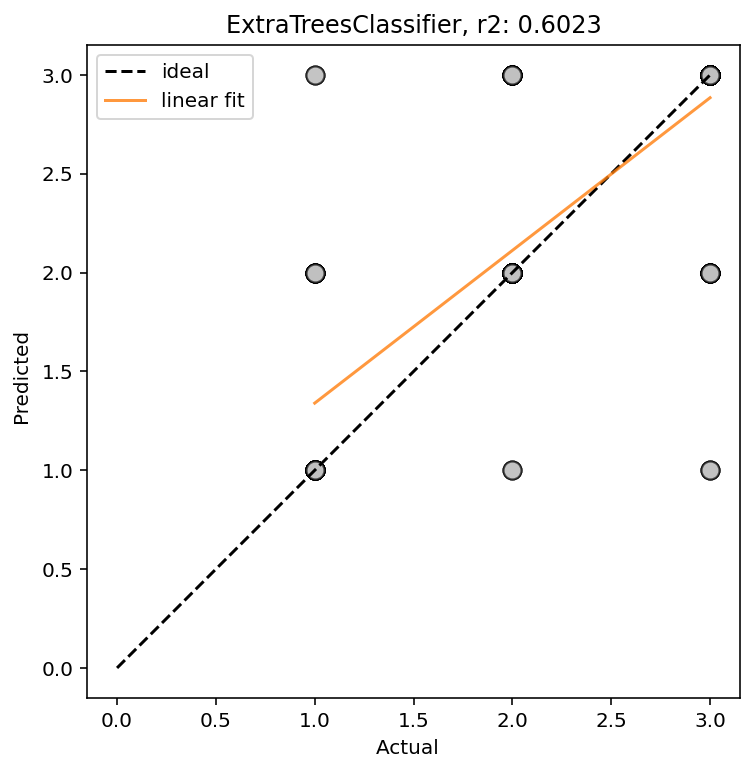

In [41]:
reg_line=True # set true or false
xy_max = np.max([np.max(y_act_test), np.max(y_pred_test)])

plot = plt.figure(figsize=(6,6))
plt.plot(y_act_test, y_pred_test, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
if reg_line:
    polyfit = np.polyfit(y_act_test, y_pred_test, deg=1)
    reg_ys = np.poly1d(polyfit)(np.unique(y_act_test))
    plt.plot(np.unique(y_act_test), reg_ys, alpha=0.8, label='linear fit')
plt.axis('scaled')
label=' '
plt.xlabel(f'Actual {label}')
plt.ylabel(f'Predicted {label}')
plt.title(f'{type(model).__name__}, r2: {r2_score(y_act_test, y_pred_test):0.4f}')
plt.legend(loc='upper left')


Saving final model

In [42]:
scaler = StandardScaler()

X_train0 = scaler.fit_transform(X_train_unscaled0)
# X_val = scaler.transform(X_val_unscaled)
# X_test = scaler.transform(X_test_unscaled)

In [43]:
from time import time
ti = time()

# model = ExtraTreesClassifier()
model.fit(X_train0, y_train0)

dt = time() - ti
print(f'Finished fitting best model, total time: {dt:0.2f} s')

Finished fitting best model, total time: 4.76 s


In [44]:
# save model
from joblib import dump, load
dump(model, '/content/drive/MyDrive/jupyter/2D/save_model/TDSL_oliynyk_ExtraTreesClassifier_full_HPO.joblib') 
#load model
# model = load('/content/drive/MyDrive/jupyter/SuperCon/save_model/oliynyk_ExtraTreesRegressor_full.joblib') 

['/content/drive/MyDrive/jupyter/2D/save_model/TDSL_oliynyk_ExtraTreesClassifier_full_HPO.joblib']

In [35]:
model = ExtraTreesClassifier()

In [36]:
from sklearn.model_selection import GridSearchCV
from time import time
params = [{'min_samples_leaf': [1,2,3,4],
         'min_samples_split': [2,3,4],
         'n_estimators': [i for i in range(50,400,50)]}]
gs_model = GridSearchCV(model,
                      param_grid=params,
                      scoring='r2',
                      cv=5)
ti = time ()
gs_model.fit(X_train, y_train1)
dt = time() -ti
print(dt)
gs_model.best_params_

433.6960778236389


{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}

In [37]:
# find best model score
gs_model.score(X_train, y_train1)

1.0